In [3]:
import numpy as np
np.set_printoptions(precision=8)
from matplotlib import pyplot as plt
from gnuradio import OFDM_OOT

In [4]:
nfft = 64
nguard = 16
ofdm_sym_sz = nfft + nguard
frame_sym_cnt = 1
ofdm_preamble = OFDM_OOT.cox_schmerzmittel(nfft, nguard, np.hstack([np.arange(25), nfft - np.arange(1, 26)]))
ofdm_preamble_f = np.fft.ifft(ofdm_preamble[-nfft:])
frame_sz = ofdm_preamble.size + ofdm_sym_sz*frame_sym_cnt
pilot_carriers_idx_group_0 = np.arange(5, 25, 4)
pilot_carriers_idx_group_1 = np.arange(-5, -25, -4)
pilot_carriers_idx = np.hstack([pilot_carriers_idx_group_0 , pilot_carriers_idx_group_1])
pilot_values_group_0 = 1.4 * np.exp(-2j*np.pi*np.arange(pilot_carriers_idx_group_0.size)/2)
pilot_values_group_1 = 1.4 * np.exp(-2j*np.pi*np.arange(pilot_carriers_idx_group_1.size)/2)
pilot_values = np.hstack([pilot_values_group_0, pilot_values_group_1])
data_carriers_idx = np.setdiff1d(np.hstack([np.arange(5, 25) , np.arange(-5, -25, -1)]), pilot_carriers_idx)
ofdm_sym = OFDM_OOT.random_ofdm_sym(nfft, data_carriers_idx, pilot_carriers_idx, pilot_values, data_modulation='qpsk')


data_frames = np.fromfile(open("rx_tx_records/frames_last_record.bin"), dtype=np.complex64).reshape((-1, frame_sz))
data_coarce_sync = np.fromfile(open("rx_tx_records/coarse_sync_last_record.bin"), dtype=np.complex64).reshape((-1, nfft))
data_precise_sync = np.fromfile(open("rx_tx_records/precise_sync_last_record.bin"), dtype=np.complex64).reshape((-1, nfft))

<IPython.core.display.Javascript object>


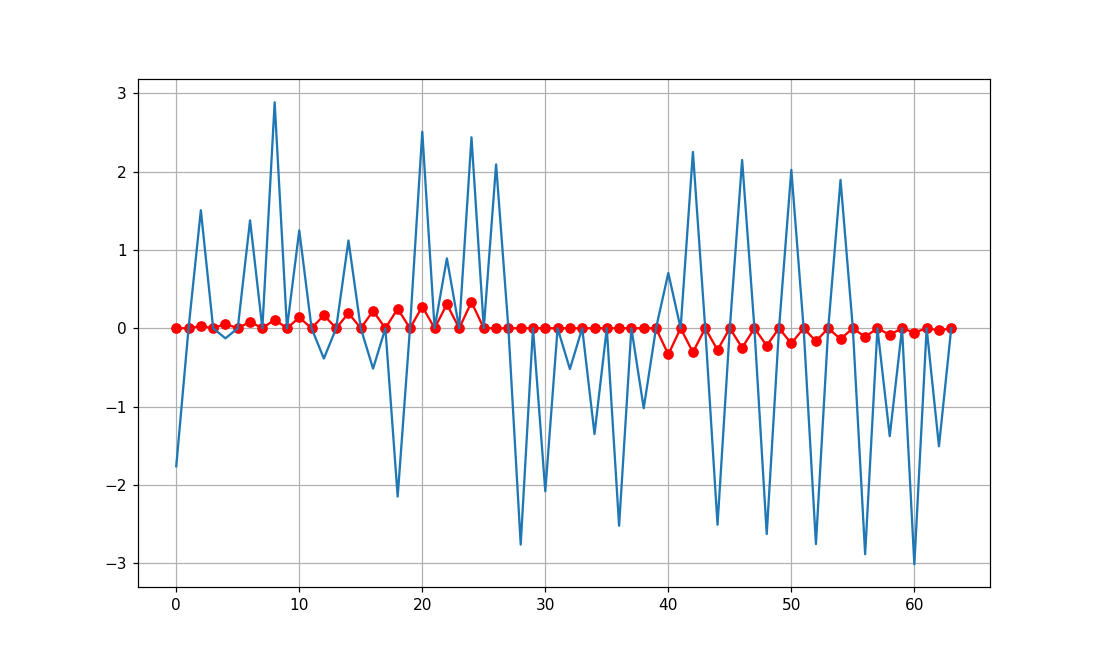

In [6]:
%matplotlib notebook

frame1_idx = -100
frame_idx_diff = 10
frame1 = data_frames[frame1_idx]
frame2 = data_frames[frame1_idx + frame_idx_diff]
preamble_1_t = frame1[nguard//2:nguard//2+nfft]
preamble_2_t = frame2[nguard//2:nguard//2+nfft]
preamble_1_f = np.fft.fft(preamble_1_t)
preamble_2_f = np.fft.fft(preamble_2_t)


fig = plt.figure(figsize=(10, 6))
ang_diff = np.angle(preamble_2_f) - np.angle(preamble_1_f)
ang_diff[ang_diff < -np.pi] += 2*np.pi
ang_diff[np.abs(ofdm_preamble_f)<1e-6] = 0
plt.plot(np.arange(ang_diff.size), ang_diff, 'ro-')
plt.plot(np.angle(preamble_1_f))
plt.grid(True)


In [12]:
ang_est = ang_diff[np.abs(ofdm_preamble_f)>1e-6] 
ang_est_idx = np.arange(ang_diff.size)[np.abs(ofdm_preamble_f)>1e-6]
ang_est_idx[ang_est_idx>ang_diff.size//2] = nfft - ang_est_idx[ang_est_idx>ang_diff.size//2]

print(np.mean(np.abs(ang_est/np.abs(ang_est_idx))))

0.013835765529165989


In [18]:
0.013/(frame_sz+200)/10/(2*np.pi)*nfft

3.678247573679359e-05

In [1]:
from gnuradio.OFDM_OOT import ofdm_preambles

ImportError: cannot import name 'ofdm_sco_sync' from 'gnuradio.OFDM_OOT.ofdm_sco_sync' (/usr/local/lib/python3.10/dist-packages/gnuradio/OFDM_OOT/ofdm_sco_sync.py)

In [2]:
ofdm_preambles.cox_schmerzmittel_cfg()

NameError: name 'ofdm_preambles' is not defined

In [26]:
def f(a, b, c):
    print(a)
    print(b)
    print(c)

f(10, *(1, 2))

10
1
2


<IPython.core.display.Javascript object>


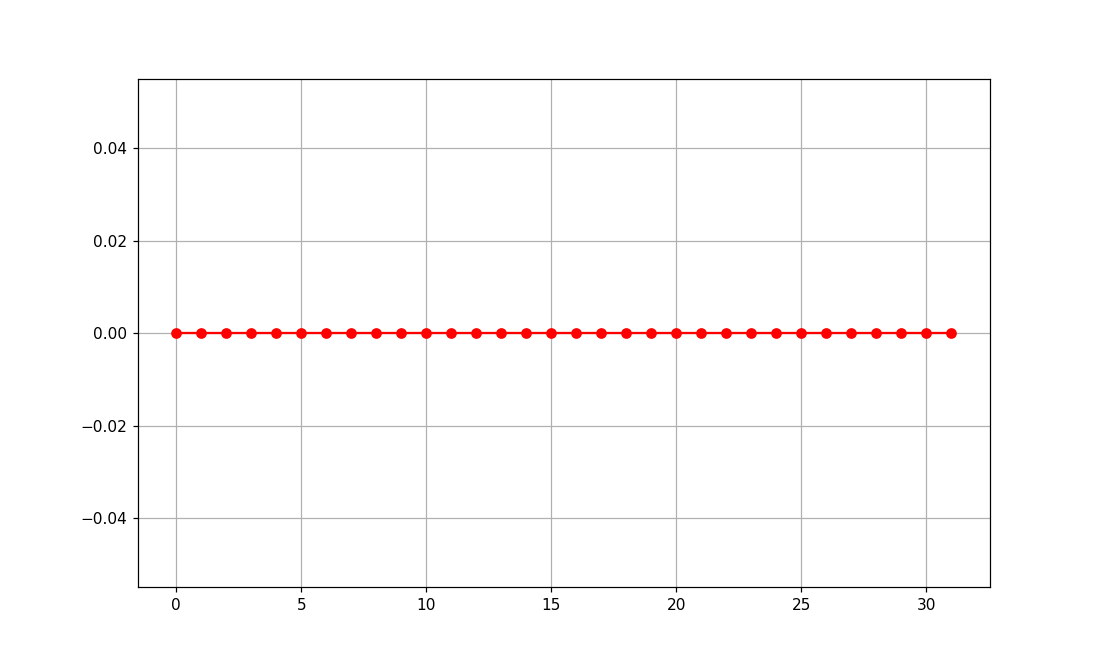

In [15]:
%matplotlib notebook

frame_idx = -100
frame = data_frames[frame1_idx]
preamble_1_t = frame[nguard//2:nguard//2+nfft//2]
preamble_2_t = frame[nguard//2+nfft//2:nguard//2+nfft]
preamble_1_f = np.fft.fft(preamble_1_t)
preamble_2_f = np.fft.fft(preamble_2_t)


fig = plt.figure(figsize=(10, 6))
ang_diff = np.angle(preamble_2_f) - np.angle(preamble_1_f)
ang_diff[ang_diff < -np.pi] += 2*np.pi
ang_diff[np.abs(preamble_1_f)<1e-6] = 0

plt.plot(np.arange(ang_diff.size), ang_diff, 'ro-')
plt.grid(True)


In [18]:
ang_diff

array([ 0.        ,  0.        ,  0.00306797,  0.        ,  0.0061348 ,
        0.        ,  0.00920201,  0.        ,  0.01227298,  0.        ,
        0.01534514,  0.        ,  0.01840947,  0.        ,  0.02146699,
        0.        ,  0.02457129,  0.        ,  0.02788573,  0.        ,
        0.03175305,  0.        ,  0.03680171,  0.        ,  0.04420296,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
       -0.0442029 ,  0.        , -0.03680176,  0.        , -0.03175305,
        0.        , -0.02788561,  0.        , -0.02457127,  0.        ,
       -0.02146692,  0.        , -0.01840946,  0.        , -0.01534509,
        0.        , -0.0122729 ,  0.        , -0.00920204,  0.        ,
       -0.00613472,  0.        , -0.00306801,  0.        ])

In [1]:
import gnuradio